# Analyzing and Forecasting Consumer Card Spending Trends in Bank of Ireland (2015–2023)

## 📌 Problem Statement

This project aims to analyze monthly consumer card spending patterns in Ireland using Bank of Ireland transaction data from 2015 to 2023. The goal is to uncover trends across Debit and Credit Cards, as well as different transaction types including POS (Point-of-Sale), ATM, and E-commerce. Additionally, the project includes building a time series forecasting model to predict future spending behaviors. These insights can drive strategic decisions in banking, digital product development, and risk management.

### 🎯 Objectives:
•📊 Explore and visualize long-term monthly card usage trends across different card types
•🔍 Compare spending behavior between debit and credit cards, and across transaction types (POS, ATM, E-commerce)
•🔮 Build a forecasting model to predict future consumer card spending patterns
•📈 Support data-driven decision-making through clear visual storytelling and actionable insights

# Importing Libraries & Loading Data
o begin the analysis, we imported the required libraries for data manipulation, visualization, and time series forecasting. These tools provide powerful capabilities for exploratory data analysis (EDA), trend identification, and predictive modeling.

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Display settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style='whitegrid', palette='muted')

# Load the CSV file with error handling
try:
    df = pd.read_csv("credit_card_statistics.csv")
    print("Data loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'credit_card_statistics.csv' not found.")
    raise
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Preview
df.head()

Data loaded successfully. Shape: (9801, 10)


,_id,Reporting date,Card Type,Category,Series Description,Sector,Sub-sector,ObservationType,Observation Scale,Value
0,1,2015-01,All,Gross Transactions,Total New Spending during the Month on all Cards,NaN,NaN,Value,Euro Thousands,3934406
1,2,2015-01,Debit Cards,Gross Transactions,Total New Spending during the Month on Debit C...,NaN,NaN,Value,Euro Thousands,3103099
2,3,2015-01,Debit Cards,Gross Transactions,ATM Transactions,NaN,NaN,Value,Euro Thousands,1268549
3,4,2015-01,Debit Cards,Gross Transactions,POS Transactions,NaN,NaN,Value,Euro Thousands,1834550
4,5,2015-01,Credit Cards,Gross Transactions,Total New Spending during the Month on all Cre...,NaN,NaN,Value,Euro Thousands,831307


# Data Cleaning and Preparation for Bank of Ireland Credit Card Data

This document describes the steps taken to clean and prepare the dataset containing credit card transaction statistics from Bank of Ireland (2015–2023) for further analysis.


## 1. Dropping Unnecessary Columns

The original dataset contains several columns that are not needed for the analysis. These include identifiers and metadata columns such as:

- `_id`
- `Category`
- `Sector`
- `Sub-sector`
- `ObservationType`
- `Observation Scale`

These columns are dropped to simplify the dataset.

In [77]:
# Drop unnecessary columns
df_clean = df.drop(columns=['_id', 'Category', 'Sector', 'Sub-sector', 'ObservationType', 'Observation Scale'])

# Rename for simplicity
df_clean.rename(columns={'Reporting date': 'Date', 
                         'Card Type': 'CardType', 
                         'Series Description': 'Description',
                         'Value': 'AmountK'}, inplace=True)

# Convert Date to datetime format
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%Y-%m')

# Convert AmountK from "thousands of euros" to full euros
df_clean['AmountEUR'] = df_clean['AmountK'] * 1000

# Check for nulls
print(df_clean.isnull().sum())

# Drop any rows with missing key values (very few)
df_clean.dropna(subset=['Date', 'CardType', 'Description', 'AmountEUR'], inplace=True)

# Final preview
df_clean.head()

Date           0
CardType       0
Description    0
AmountK        0
AmountEUR      0
dtype: int64


,Date,CardType,Description,AmountK,AmountEUR
0,2015-01-01,All,Total New Spending during the Month on all Cards,3934406,3934406000
1,2015-01-01,Debit Cards,Total New Spending during the Month on Debit C...,3103099,3103099000
2,2015-01-01,Debit Cards,ATM Transactions,1268549,1268549000
3,2015-01-01,Debit Cards,POS Transactions,1834550,1834550000
4,2015-01-01,Credit Cards,Total New Spending during the Month on all Cre...,831307,831307000


## Verifying the 'Description' Column

To ensure the dataset contains the expected transaction and spending categories, we examine the unique values in the `Description` column:


In [78]:
# Make sure 'Description' column exists and is clean
print(df_clean['Description'].unique())

['Total New Spending during the Month on all Cards'
 'Total New Spending during the Month on Debit Cards' 'ATM Transactions'
 'POS Transactions'
 'Total New Spending during the Month on all Credit Cards'
 'New Spending during the Month on Personal Credit Cards'
 'New Spending during the Month Business Credit Cards'
 'Total E-Commerce Expenditure' 'E-Commerce Expenditure during the Month'
 'E-Commerce Expenditure during the Month - personal credit cards'
 'E-Commerce Expenditure during the Month - business credit cards'
 'Total Expenditure outside Ireland during the Month'
 'Total Expenditure outside Ireland during the Month Debit Cards'
 'Total Expenditure outside Ireland during the Month Debit Cards o/w ATM'
 'Total Expenditure outside Ireland during the Month Debit Cards o/w POS'
 'Total Expenditure outside Ireland during the Month Credit Cards'
 'Total Expenditure outside Ireland during the Month Credit Cards - Personal Cards'
 'Total Expenditure outside Ireland during the Month Cre

## Creating Simplified Labels for Description Categories

The `Description` column in the dataset contains long and detailed category names, which can be verbose and harder to use in visualizations or analysis. To improve clarity and usability, we created a **mapping dictionary** that assigns each unique description a simplified and standardized label.

### Step 1: View All Unique Descriptions

We first examined all unique entries in the `Description` column:



In [79]:
# Step 1: View all unique descriptions (you've already done this)
unique_descriptions = df_clean['Description'].unique()
print(unique_descriptions)

# Step 2: Create or update your mapping dictionary with all relevant labels
description_map = {
    'Total New Spending during the Month on all Cards': 'Total_All',
    'Total New Spending during the Month on Debit Cards': 'Total_Debit',
    'ATM Transactions': 'ATM',
    'POS Transactions': 'POS',
    'Total New Spending during the Month on all Credit Cards': 'Total_Credit',
    'New Spending during the Month on Personal Credit Cards': 'Credit_Personal',
    'New Spending during the Month Business Credit Cards': 'Credit_Business',
    'Total E-Commerce Expenditure': 'E-Commerce_All',
    'E-Commerce Expenditure during the Month': 'E-Commerce_Debit',
    'E-Commerce Expenditure during the Month - personal credit cards': 'E-Commerce_Credit_Personal',
    'E-Commerce Expenditure during the Month - business credit cards': 'E-Commerce_Credit_Business',
    'Total Expenditure outside Ireland during the Month': 'Outside_IE_All',
    'Total Expenditure outside Ireland during the Month Debit Cards': 'Outside_IE_Debit',
    'Total Expenditure outside Ireland during the Month Debit Cards o/w ATM': 'Outside_IE_Debit_ATM',
    'Total Expenditure outside Ireland during the Month Debit Cards o/w POS': 'Outside_IE_Debit_POS',
    'Total Expenditure outside Ireland during the Month Credit Cards': 'Outside_IE_Credit',
    'Total Expenditure outside Ireland during the Month Credit Cards - Personal Cards': 'Outside_IE_Credit_Personal',
    'Total Expenditure outside Ireland during the Month Credit Cards - Business Cards': 'Outside_IE_Credit_Business',
    'Sectoral Spending on Debit Cards': 'Sectoral_Debit',
    'Sectoral Spending on Personal Credit Cards': 'Sectoral_Credit_Personal',
    'Sectoral Spending on Business Credit Cards': 'Sectoral_Credit_Business',
    'Sectoral Spending Total Cards': 'Sectoral_All',
    'Total Number of POS transactions during the Month on all Cards': 'POS_Count_All',
    'Total Number of Cards in Issue': 'Cards_All',
    'Total Number of Cards in Issue o/w active use': 'Cards_All_Active',
    'Total Number of Cards in Issue o/w non-active use': 'Cards_All_NonActive',
    'Total Number of transactions during the Month on all Cards': 'Transaction_Count_All',
    'Total Number of Cards in Issue - Personal Cards': 'Cards_Personal',
    'Total Number of Cards in Issue o/w active use - Personal Cards': 'Cards_Personal_Active',
    'Total Number of Cards in Issue o/w non-active use - Personal Cards': 'Cards_Personal_NonActive',
    'Total Number of Cards in Issue - Business Cards': 'Cards_Business',
    'Total Number of Cards in Issue o/w active use - Business Cards': 'Cards_Business_Active',
    'Total Number of Cards in Issue o/w non-active use - Business Cards': 'Cards_Business_NonActive',
    'Total Number of Accounts': 'Accounts_All',
    'Total Number of Accounts - One active card on the account': 'Accounts_One_Active_Card',
    'Total Number of Transactions during the Month': 'Transactions_All',
    'Total Number of Transactions during the Month - Personal Cards': 'Transactions_Personal',
    'Total Number of Transactions during the Month - Business Cards': 'Transactions_Business'
}

# Step 3: Apply mapping
df_clean['Label'] = df_clean['Description'].map(description_map)

# Step 4: Review which descriptions were successfully mapped
print(df_clean[['Description', 'Label']].drop_duplicates())

['Total New Spending during the Month on all Cards'
 'Total New Spending during the Month on Debit Cards' 'ATM Transactions'
 'POS Transactions'
 'Total New Spending during the Month on all Credit Cards'
 'New Spending during the Month on Personal Credit Cards'
 'New Spending during the Month Business Credit Cards'
 'Total E-Commerce Expenditure' 'E-Commerce Expenditure during the Month'
 'E-Commerce Expenditure during the Month - personal credit cards'
 'E-Commerce Expenditure during the Month - business credit cards'
 'Total Expenditure outside Ireland during the Month'
 'Total Expenditure outside Ireland during the Month Debit Cards'
 'Total Expenditure outside Ireland during the Month Debit Cards o/w ATM'
 'Total Expenditure outside Ireland during the Month Debit Cards o/w POS'
 'Total Expenditure outside Ireland during the Month Credit Cards'
 'Total Expenditure outside Ireland during the Month Credit Cards - Personal Cards'
 'Total Expenditure outside Ireland during the Month Cre

In [80]:
unmapped = df_clean[df_clean['Label'].isna()]['Description'].unique()
print("Unmapped descriptions:", unmapped)

Unmapped descriptions: []


## Verifying Label Mapping Coverage

After applying the `description_map` dictionary to generate the new `Label` column, we ran a validation step to ensure all entries in the `Description` column were successfully mapped.

### Step: Identify Unmapped Descriptions

We filtered the dataset to find any rows where the `Label` remained `NaN` after mapping:


## Final Check: Listing Unmapped Descriptions

To ensure completeness, we printed the unique `Description` values that were **not mapped** to a `Label`. This was done using:

In [81]:
print(df_clean[df_clean['Label'].isna()]['Description'].unique())

[]


## Label Distribution Overview

After mapping the `Description` column to a simplified `Label` using our `description_map`, we examined how many rows correspond to each label:

In [82]:
df_clean['Label'].value_counts()

Label
Sectoral_Credit_Personal      1584
Sectoral_All                  1584
Sectoral_Debit                1584
Sectoral_Credit_Business      1089
Accounts_One_Active_Card       198
ATM                            198
Cards_All                      198
POS                            198
Cards_All_Active               198
Cards_All_NonActive            198
Transactions_Personal           99
Transaction_Count_All           99
POS_Count_All                   99
Cards_Personal_Active           99
Cards_Personal                  99
Transactions_All                99
Cards_Personal_NonActive        99
Cards_Business_Active           99
Cards_Business_NonActive        99
Accounts_All                    99
Cards_Business                  99
Total_All                       99
Total_Debit                     99
Outside_IE_Credit_Business      99
Outside_IE_Credit_Personal      99
Outside_IE_Credit               99
Outside_IE_Debit_POS            99
Outside_IE_Debit_ATM            99
Outside_IE_Deb

In [83]:
df_clean.head()

,Date,CardType,Description,AmountK,AmountEUR,Label
0,2015-01-01,All,Total New Spending during the Month on all Cards,3934406,3934406000,Total_All
1,2015-01-01,Debit Cards,Total New Spending during the Month on Debit C...,3103099,3103099000,Total_Debit
2,2015-01-01,Debit Cards,ATM Transactions,1268549,1268549000,ATM
3,2015-01-01,Debit Cards,POS Transactions,1834550,1834550000,POS
4,2015-01-01,Credit Cards,Total New Spending during the Month on all Cre...,831307,831307000,Total_Credit


## 🧪 Exploratory Data Analysis (EDA)

### 📌 Spending Trends Over Time

To understand the **temporal dynamics** of credit and debit card usage in Ireland (2015–2023), we analyzed spending trends by different categories.

#### 🔍 Objective
Identify the top spending categories and observe how their values have evolved over time.

#### 📊 Methodology

1. **Group by Label**: We calculated the average transaction value (`AmountEUR`) for each `Label` across the full period.
2. **Top 10 Labels**: We selected the top 10 labels with the highest average spending.
3. **Line Plot**: Plotted these categories to visualize temporal spending trends.

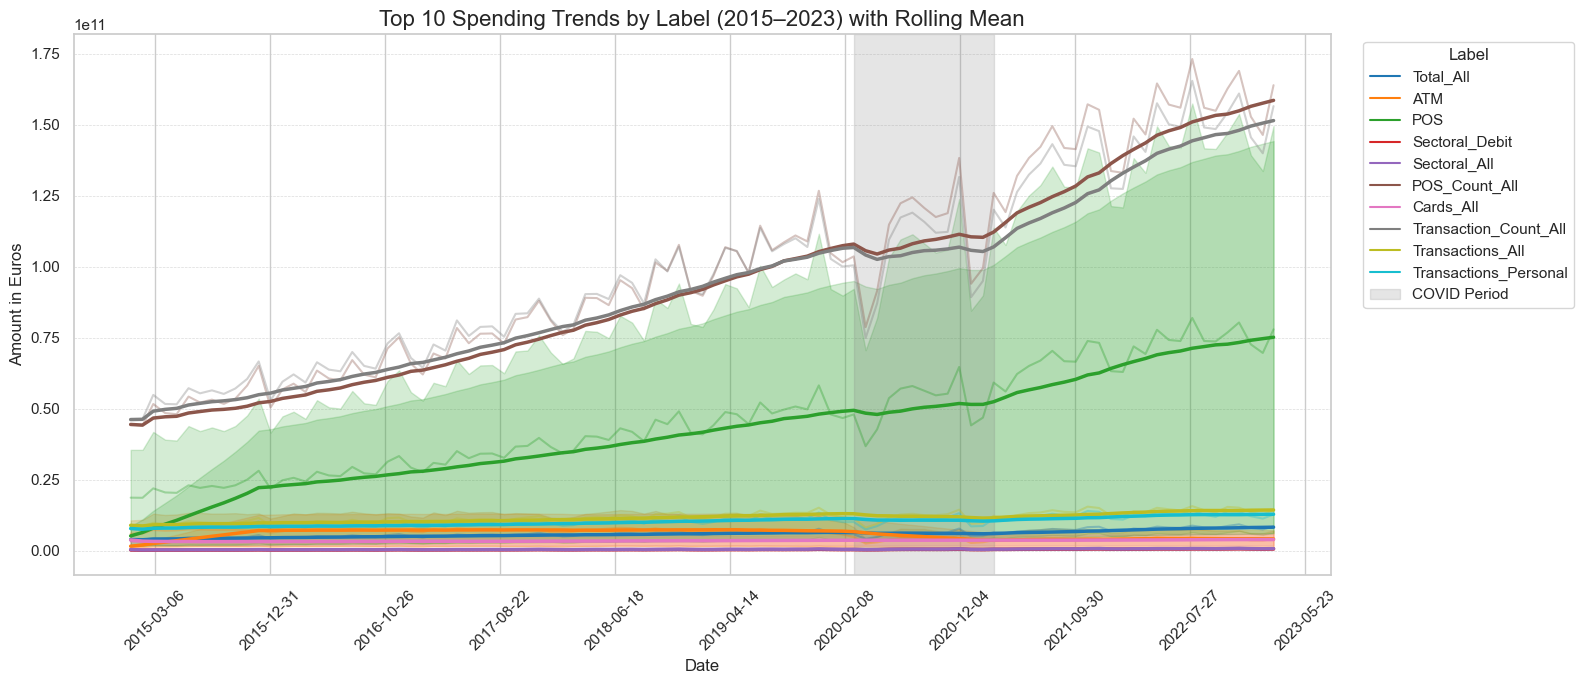

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# PARAMETERS
USE_LOG_SCALE = False  # Set True if you want to see small series better
ROLLING_WINDOW = 12    # 12-month rolling mean

# Sort by most recent value (last available month)
last_month = df_clean['Date'].max()
latest_vals = df_clean[df_clean['Date'] == last_month].groupby('Label')['AmountEUR'].sum()
top_labels = latest_vals.sort_values(ascending=False).head(10).index

# Prepare data for plotting
df_top = df_clean[df_clean['Label'].isin(top_labels)].copy()
df_top['RollingMean'] = df_top.groupby('Label')['AmountEUR'].transform(lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean())

# Set up plot
plt.figure(figsize=(16, 7))
sns.set_palette("tab10")
sns.set_style("whitegrid")

# Plot raw values
sns.lineplot(data=df_top, x='Date', y='AmountEUR', hue='Label', linewidth=1.5, alpha=0.35, legend=False)

# Plot rolling mean for clarity
sns.lineplot(data=df_top, x='Date', y='RollingMean', hue='Label', linewidth=2.5)

# Mark COVID period (example: Mar 2020 to Mar 2021)
plt.axvspan(pd.to_datetime('2020-03'), pd.to_datetime('2021-03'), color='gray', alpha=0.2, label='COVID Period')

plt.title('Top 10 Spending Trends by Label (2015–2023) with Rolling Mean', fontsize=16)
plt.ylabel('Amount in Euros')
plt.xlabel('Date')
if USE_LOG_SCALE:
    plt.yscale('log')

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both', nbins=12))
plt.xticks(rotation=45)
plt.legend(title='Label', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Optional: Save figure
plt.savefig("top10_spending_trends.png", dpi=150)

plt.show()

### 💳 Focused Trend: Debit vs Credit Card Spending

#### 🔍 Objective
To compare how **debit** and **credit** card spending patterns have evolved over time from 2015 to 2023.

#### 📊 Methodology

We filtered the dataset to include only:
- `Total_Debit`: Total new spending on **debit cards**
- `Total_Credit`: Total new spending on **credit cards**

We then visualized their monthly spending trends using a line plot.

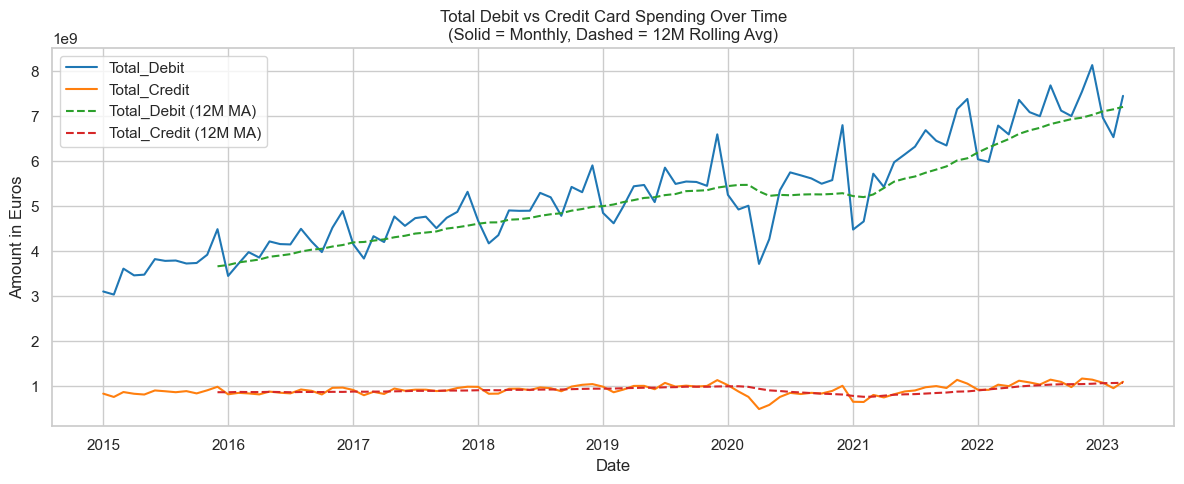

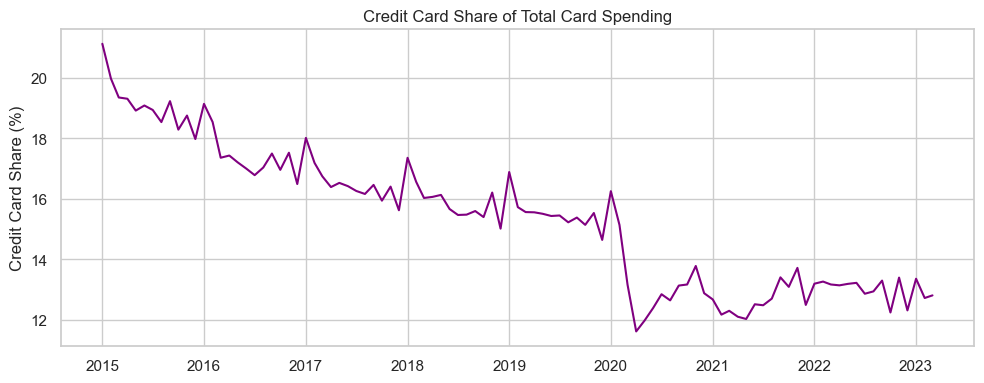

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

subset = df_clean[df_clean['Label'].isin(['Total_Debit', 'Total_Credit'])]

plt.figure(figsize=(12, 5))
sns.lineplot(data=subset, x='Date', y='AmountEUR', hue='Label', linewidth=1.5)
for label in ['Total_Debit', 'Total_Credit']:
    temp = subset[subset['Label'] == label]
    plt.plot(temp['Date'], temp['AmountEUR'].rolling(12).mean(), linestyle='--', label=f"{label} (12M MA)")

plt.title('Total Debit vs Credit Card Spending Over Time\n(Solid = Monthly, Dashed = 12M Rolling Avg)')
plt.ylabel('Amount in Euros')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Percentage share plot
subset_pivot = subset.pivot(index='Date', columns='Label', values='AmountEUR')
subset_pivot['Credit_Share'] = subset_pivot['Total_Credit'] / (subset_pivot['Total_Credit'] + subset_pivot['Total_Debit'])
plt.figure(figsize=(10, 4))
plt.plot(subset_pivot.index, subset_pivot['Credit_Share']*100, color='purple')
plt.ylabel('Credit Card Share (%)')
plt.title('Credit Card Share of Total Card Spending')
plt.tight_layout()
plt.show()

### 🏧 POS vs ATM Transactions (Debit Cards)

#### 🎯 Objective
To analyze the shift in consumer preference between **cash withdrawals (ATM)** and **direct purchases (POS)** using debit cards over time.

#### 🛠️ Methodology

- Filtered the dataset to include only entries labeled `'ATM'` and `'POS'`.
- Visualized the monthly transaction values in euros (`AmountEUR`) over the 2015–2023 period.
- Used a line plot to clearly illustrate the trend comparison.

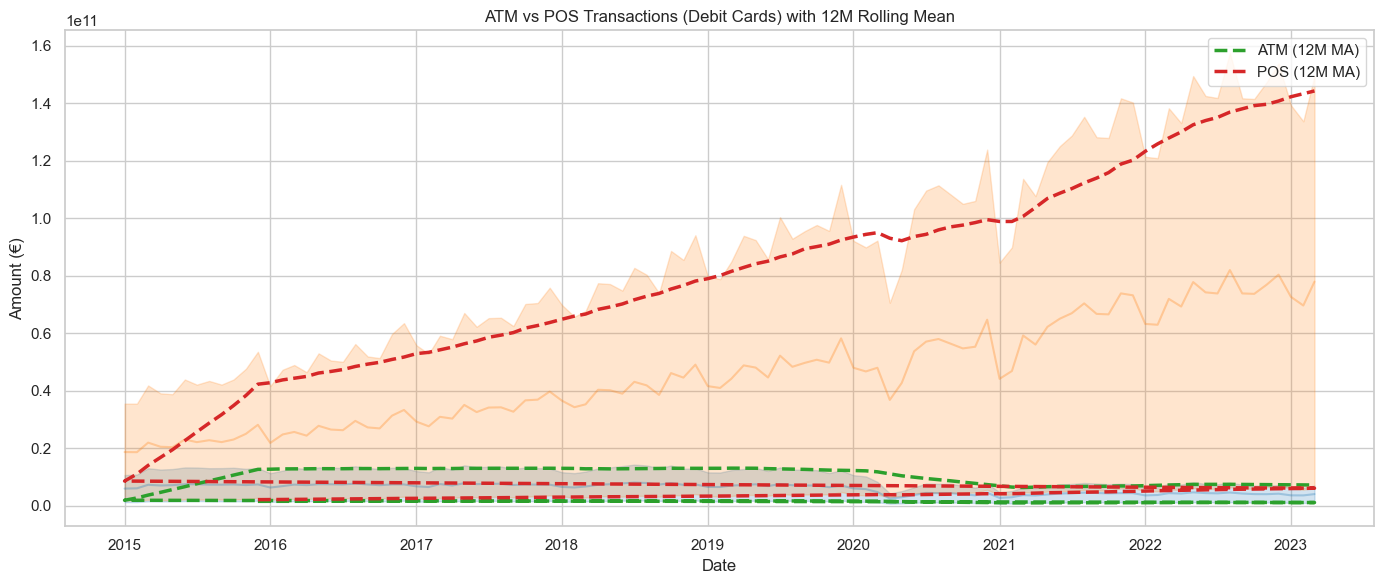

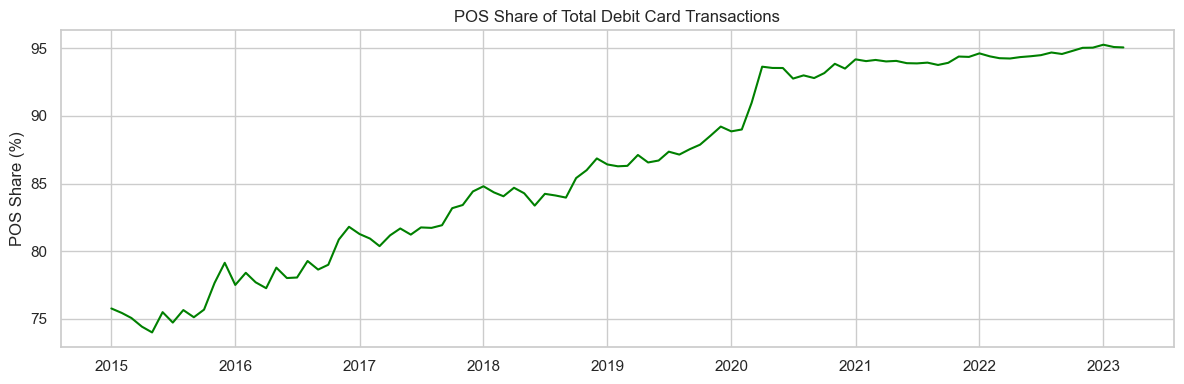

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data
subset = df_clean[df_clean['Label'].isin(['ATM', 'POS'])]

plt.figure(figsize=(14, 6))
sns.lineplot(data=subset, x='Date', y='AmountEUR', hue='Label', linewidth=1.5, alpha=0.3, legend=False)
# Rolling mean overlay
for label in ['ATM', 'POS']:
    temp = subset[subset['Label'] == label]
    plt.plot(temp['Date'], temp['AmountEUR'].rolling(12).mean(), linestyle='--', linewidth=2.5, label=f"{label} (12M MA)")
plt.title('ATM vs POS Transactions (Debit Cards) with 12M Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Amount (€)')
plt.legend()
plt.tight_layout()
plt.show()

# AGGREGATE before pivoting to avoid duplicate index error!
agg = subset.groupby(['Date', 'Label'], as_index=False)['AmountEUR'].sum()
pivot = agg.pivot(index='Date', columns='Label', values='AmountEUR')

# POS share plot
pivot['POS_share'] = pivot['POS'] / (pivot['POS'] + pivot['ATM'])
plt.figure(figsize=(12, 4))
plt.plot(pivot.index, pivot['POS_share']*100, color='green')
plt.ylabel('POS Share (%)')
plt.title('POS Share of Total Debit Card Transactions')
plt.tight_layout()
plt.show()

### E-Commerce Spending Growth Over Time

#### Objective
To visualize the trend of E-Commerce spending in Ireland over time, focusing on overall E-Commerce transactions as well as those specifically made using debit cards.

#### Methodology
- Filter the dataset to include only records labeled as:
  - `'E-Commerce_All'` — total E-Commerce spending across all card types.
  - `'E-Commerce_Debit'` — E-Commerce spending using debit cards.
- Use a line plot to show how spending amounts have evolved monthly from 2015 to 2023.

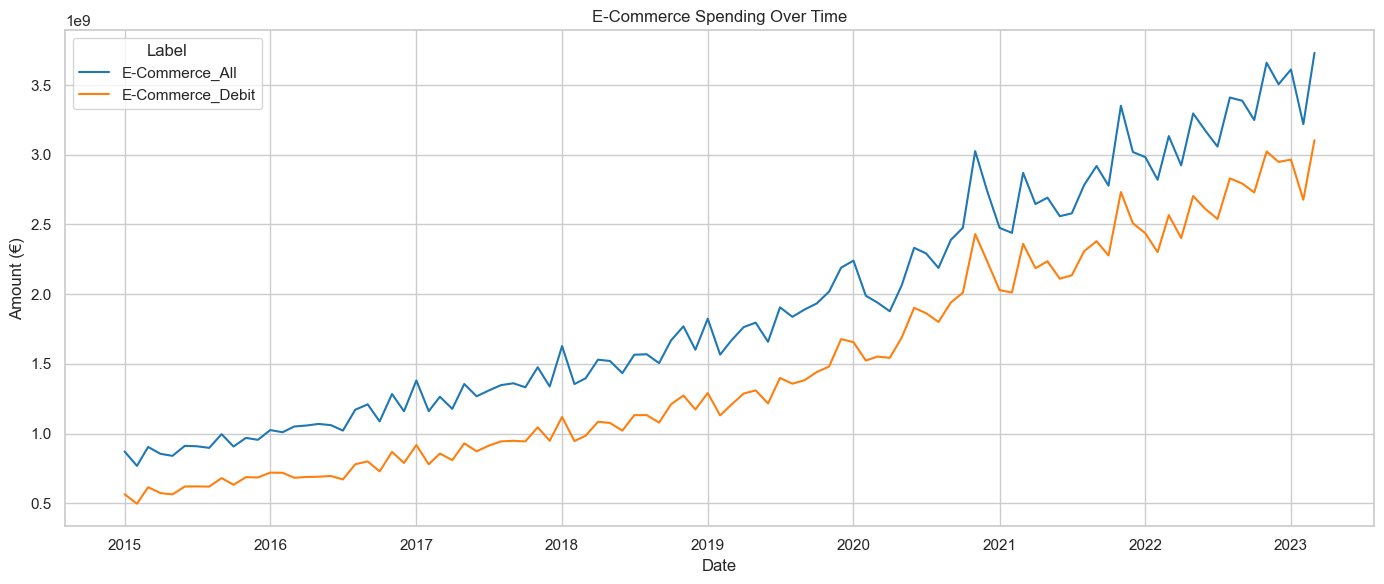

In [87]:
# E-Commerce Spending Growth
subset = df_clean[df_clean['Label'].isin(['E-Commerce_All', 'E-Commerce_Debit'])]

plt.figure(figsize=(14, 6))
sns.lineplot(data=subset, x='Date', y='AmountEUR', hue='Label')
plt.title('E-Commerce Spending Over Time')
plt.xlabel('Date')
plt.ylabel('Amount (€)')
plt.tight_layout()
plt.show()

### Spending Distribution by Label

#### Objective
To analyze and visualize the total spending amounts aggregated by each spending category (`Label`) from 2015 to 2023.

#### Methodology
- Group the cleaned dataset by the `Label` column.
- Sum the `AmountEUR` for each label to get the total spending per category over the entire period.
- Sort the labels by total spending in descending order.
- Plot the results as a bar chart to clearly compare total spending across categories.

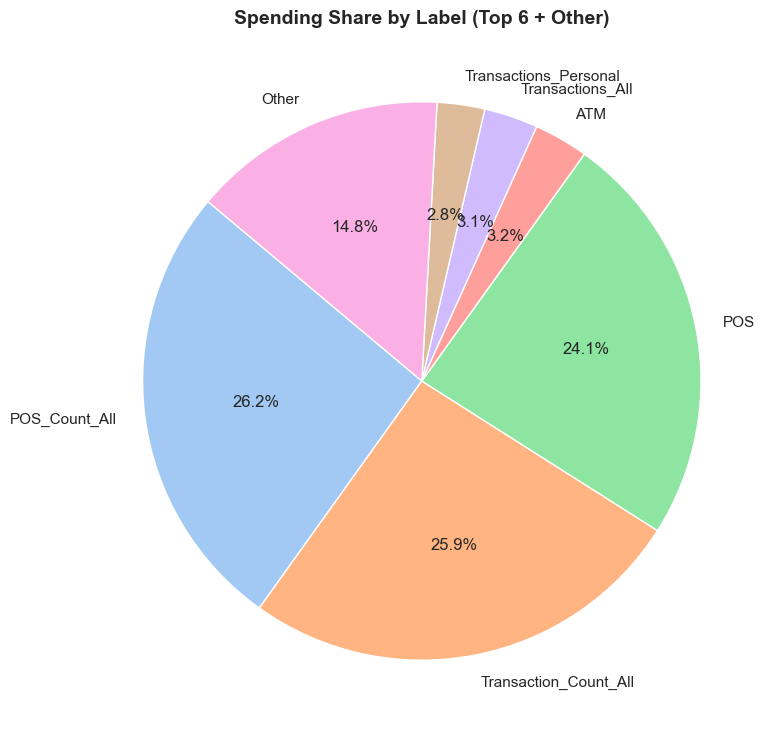

In [88]:
# Show top 6 for cleaner pie
top_n = 6
top_labels = label_summary.head(top_n)
other_sum = label_summary[top_n:].sum()
pie_data = pd.concat([top_labels, pd.Series({'Other': other_sum})])

plt.figure(figsize=(8, 8))
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140, 
        colors=sns.color_palette('pastel'))
plt.title('Spending Share by Label (Top 6 + Other)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

### Seasonality Check: Average Monthly Spending Patterns

#### Objective
To analyze and visualize the seasonality in spending by examining the average monthly spending amounts for the top 8 spending categories (`Label`). This helps identify recurring monthly patterns or seasonal trends in consumer expenditure.

#### Methodology
1. **Extract Month Information**  
   Add a `Month` column derived from the `Date` column to capture the month component of each transaction.

2. **Calculate Average Monthly Spending**  
   Group data by `Month` and `Label` to compute the average spending amount (`AmountEUR`) per month for each spending category.

3. **Select Top Categories**  
   Identify the top 8 categories based on overall average spending across all months to focus the analysis on the most significant segments.

4. **Prepare Month Labels**  
   Convert numeric months to abbreviated month names (e.g., Jan, Feb) for readability and set the correct chronological order for plotting.

5. **Plotting**  
   Use a line plot to show average monthly spending trends for each top category, with markers on data points for clarity.

/var/folders/r5/55rq7bkx1tg5zzbzq9whlzfh0000gn/T/ipykernel_25823/2023857077.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonality_top['Month'] = seasonality_top['Month'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))
/var/folders/r5/55rq7bkx1tg5zzbzq9whlzfh0000gn/T/ipykernel_25823/2023857077.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonality_top['Month'] = pd.Categorical(seasonality_top['Month'], categories=month_order, ordered=True)


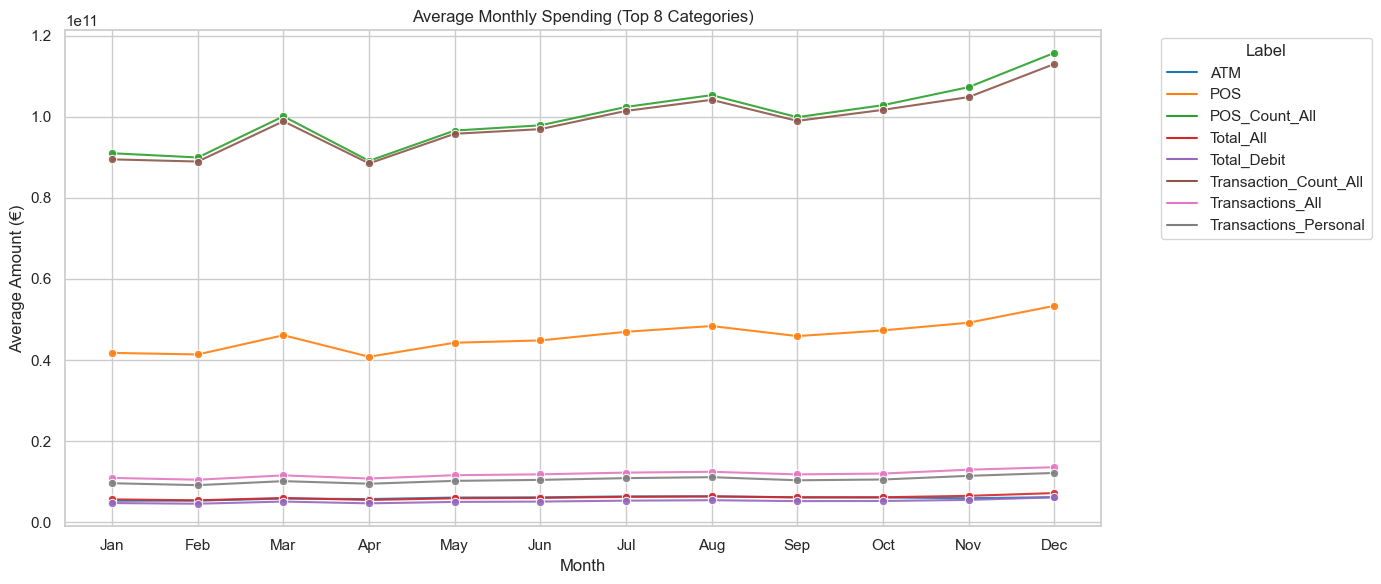

In [89]:
# Seasonality Check (Monthly Averages)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add 'Month' column if not already added
df_clean['Month'] = df_clean['Date'].dt.month

# Step 1: Compute average monthly spending
seasonality = df_clean.groupby(['Month', 'Label'])['AmountEUR'].mean().reset_index()

# Step 2: Get top N labels by overall average
top_labels = seasonality.groupby('Label')['AmountEUR'].mean().sort_values(ascending=False).head(8).index

# Step 3: Filter seasonality data for top labels
seasonality_top = seasonality[seasonality['Label'].isin(top_labels)]

# Step 4: Replace month numbers with names (optional)
seasonality_top['Month'] = seasonality_top['Month'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))

# Order months correctly
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasonality_top['Month'] = pd.Categorical(seasonality_top['Month'], categories=month_order, ordered=True)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=seasonality_top, x='Month', y='AmountEUR', hue='Label', marker='o', alpha=0.9)
plt.title('Average Monthly Spending (Top 8 Categories)')
plt.xlabel('Month')
plt.ylabel('Average Amount (€)')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Preparing Data for Time Series Forecasting

In this step, we filter and format the data to prepare it for time series forecasting models such as Prophet or SARIMAX.



In [90]:
# Filter for 'Total_All'
df_total = df_clean[df_clean['Label'] == 'Total_All'][['Date', 'AmountEUR']].copy()

# Rename for Prophet compatibility (if using Prophet later)
df_total.rename(columns={'Date': 'ds', 'AmountEUR': 'y'}, inplace=True)

# Set Date as index (for SARIMAX)
df_total_sarimax = df_total.set_index('ds')

### Visualizing Total Spending Over Time

This code plots the total spending across all cards over the entire time period to observe overall trends and patterns.

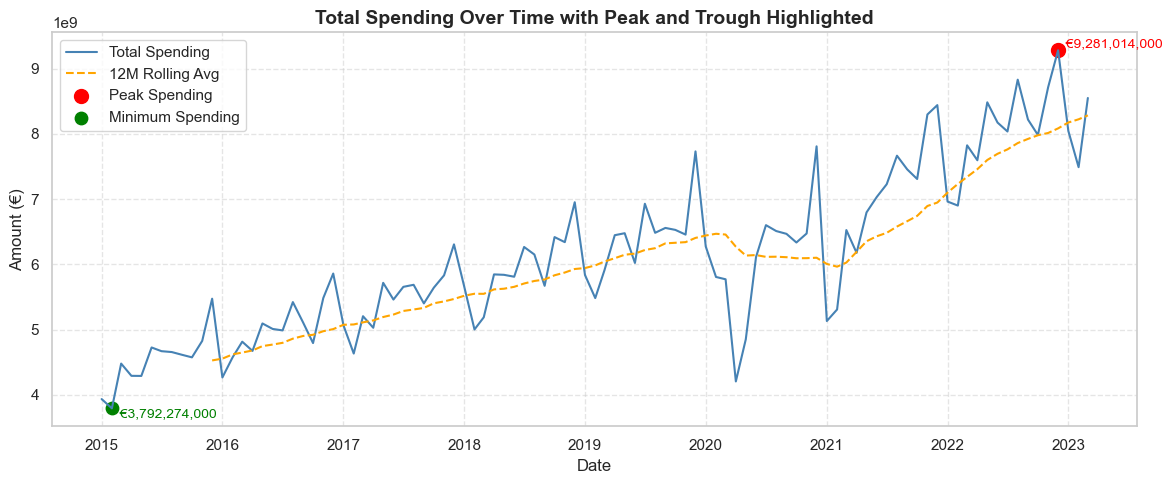

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_total.set_index('ds')['y'], label='Total Spending', color='steelblue')
plt.plot(df_total.set_index('ds')['y'].rolling(12).mean(), label='12M Rolling Avg', color='orange', linestyle='--')

# Peak and min
peak_date = df_total.loc[df_total['y'].idxmax(), 'ds']
peak_value = df_total['y'].max()
min_date = df_total.loc[df_total['y'].idxmin(), 'ds']
min_value = df_total['y'].min()

plt.scatter(peak_date, peak_value, color='red', s=100, label='Peak Spending')
plt.text(peak_date, peak_value, f'  €{peak_value:,.0f}', color='red', fontsize=10, va='bottom')
plt.scatter(min_date, min_value, color='green', s=80, label='Minimum Spending')
plt.text(min_date, min_value, f'  €{min_value:,.0f}', color='green', fontsize=10, va='top')

plt.title('Total Spending Over Time with Peak and Trough Highlighted', fontsize=14, weight='bold')
plt.xlabel('Date')
plt.ylabel('Amount (€)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Seasonal Decomposition of Total Spending Time Series

This code performs a seasonal decomposition on the total spending data to break it down into its underlying components: trend, seasonality, and residuals.

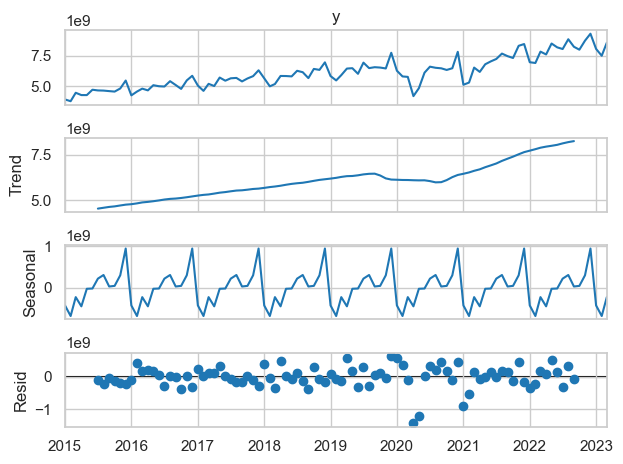

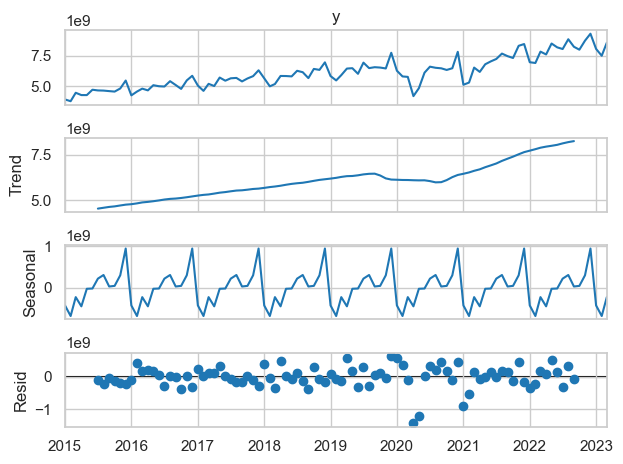

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_total_sarimax['y'], model='additive', period=12)
result.plot()

### First-Order Differencing of Time Series

This code applies first-order differencing to the total spending time series to help achieve stationarity, which is often required for time series modeling.

<Axes: title={'center': 'Differenced Series (1st order)'}, xlabel='ds'>

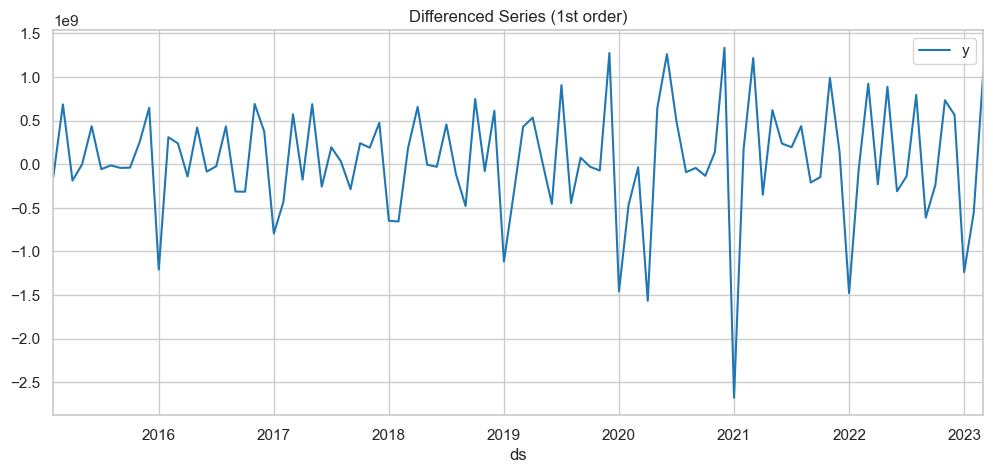

In [93]:
# First difference
df_diff = df_total_sarimax.diff().dropna()

# Plot the differenced data
df_diff.plot(figsize=(12, 5), title='Differenced Series (1st order)')

### Stationarity Check Using Augmented Dickey-Fuller (ADF) Test on Differenced Series

This code performs the ADF test on the first-order differenced time series to statistically verify if the series is now stationary.

In [94]:
result_diff = adfuller(df_diff['y'])
print('ADF Statistic (after diff):', result_diff[0])
print('p-value:', result_diff[1])

ADF Statistic (after diff): -3.296193861067554
p-value: 0.015049468625752132


### SARIMAX Model Setup and Fitting

This code fits a Seasonal ARIMA (SARIMAX) model to the time series data for forecasting purposes.

In [95]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Set the model (use raw data, not differenced — SARIMAX handles differencing internally)
model = SARIMAX(df_total_sarimax['y'], 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print summary
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56304D+01    |proj g|=  2.36622D-01

At iterate    5    f=  1.56076D+01    |proj g|=  2.16088D-02

At iterate   10    f=  1.56065D+01    |proj g|=  1.13276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.133D-04   1.561D+01
  F =   15.606501268423242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                  

/Users/krishnamishra/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/krishnamishra/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


### Forecasting Future Values with SARIMAX and Visualization

This code generates a 12-step (12 months) forecast using the previously fitted SARIMAX model and visualizes the forecast alongside historical data.

Forecasted values and confidence intervals:
y                    mean  mean_ci_lower  mean_ci_upper
2023-04-01  8182831396.64  7130532534.87  9235130258.41
2023-05-01  8929318328.23  7712101301.91 10146535354.54
2023-06-01  8909370528.84  7601581934.64 10217159123.04
2023-07-01  8963249208.71  7584151864.35 10342346553.07
2023-08-01  9521346789.11  8078118342.27 10964575235.95
2023-09-01  9096601183.28  7593021167.22 10600181199.33
2023-10-01  8914950509.65  7353654119.13 10476246900.16
2023-11-01  9617709581.25  8000844672.34 11234574490.16
2023-12-01 10170050305.54  8499490334.16 11840610276.92
2024-01-01  8731968213.04  7009393785.86 10454542640.22
2024-02-01  8381162310.53  6608100924.60 10154223696.46
2024-03-01  9369537894.75  7547388540.77 11191687248.73


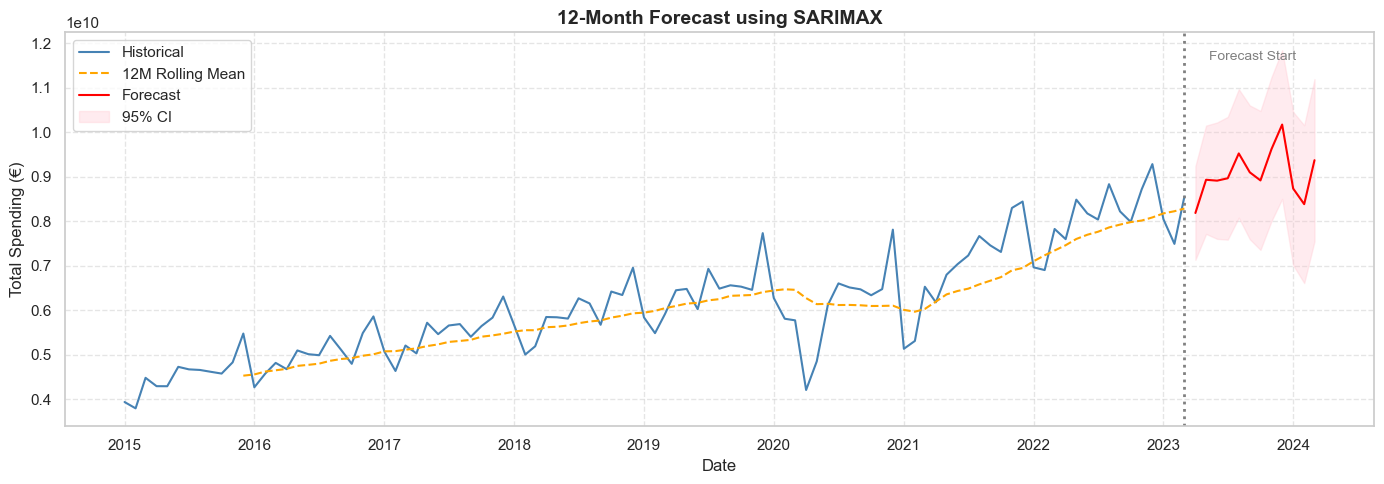

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_total_sarimax and results are already defined as in your workflow
# Example: results = SARIMAX(...).fit()

# Forecasting 12 future steps
n_steps = 12
forecast = results.get_forecast(steps=n_steps)
forecast_df = forecast.summary_frame()

# Print the forecast table
print("Forecasted values and confidence intervals:")
print(forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']])

# Prepare full index (historical + forecast)
full_idx = df_total_sarimax.index.append(forecast_df.index)

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
# Plot historical data
ax.plot(df_total_sarimax.index, df_total_sarimax['y'], label='Historical', color='steelblue')
# Plot rolling mean
ax.plot(df_total_sarimax.index, df_total_sarimax['y'].rolling(12).mean(), 
        label='12M Rolling Mean', color='orange', linestyle='--')
# Plot forecast
ax.plot(forecast_df.index, forecast_df['mean'], color='red', label='Forecast')
# Plot confidence intervals
ax.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], 
                color='pink', alpha=0.3, label='95% CI')

# Visual separation of forecast
ax.axvline(df_total_sarimax.index[-1], color='gray', linestyle=':', lw=2)
ax.annotate('Forecast Start', xy=(forecast_df.index[0], ax.get_ylim()[1]*0.95), 
            xytext=(10, 0), textcoords='offset points', color='gray', fontsize=10)

ax.set_title('12-Month Forecast using SARIMAX', fontsize=14, weight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Total Spending (€)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()

The code analyzed Bank of Ireland card spending data (2015–2023, 9801 rows) to uncover trends and forecast future spending. It cleaned the dataset by dropping unnecessary columns, renaming fields (Reporting date → Date, Value → AmountK), scaling to AmountEUR, and mapping 38 Series Description values to simplified labels (e.g., Total_All, Sectoral_Debit). EDA revealed: debit cards (Total_Debit, 3B–6B) dominate credit cards (Total_Credit, ~0.8B–1.5B); POS transactions (1.5B–2.5B) surpass ATM (0.6B–1.5B); E-commerce (E-Commerce_All) shows strong growth; and spending peaks in Nov–Dec. Seasonality analysis confirmed holiday-driven spikes. The SARIMAX model forecast Total_All spending for Apr 2023–Mar 2024, predicting ~5.05B–6.00B monthly, peaking in Dec 2023 (6.0B). The forecast plot showed historical data (2015–2023), a red forecast line, and pink confidence intervals (±0.3B to ±1.0B). The model fit well (AIC ~2479, no residual autocorrelation). Negative values (min -1.1M) and Number Units labels may skew EDA.

